In [12]:
import numpy as np
import tensorflow as tf
from support_function.read_data import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Metric
from support_function.reporting import reporting
from support_function.evaluate import *

In [13]:
df_normalized = read_cleaned_data()


In [14]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=first_y, test_size=0.2, random_state=40
)
y = np.stack((first_y, second_y), axis=1)
y_array2d = np.stack((first_y_train, second_y_train), axis=1)
y_test_array2d = np.stack((first_y_test, second_y_test), axis=1)

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(14,)),  
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [16]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(
        self,
        from_logits=False,
        reduction=tf.keras.losses.Reduction.AUTO,
        name="custom_sparse_categorical_crossentropy",
    ):
        super().__init__(reduction=reduction, name=name)
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        # Calculate the standard sparse categorical crossentropy loss
        min_losses = []
        first_label = tf.cast(y_true[:, 0], tf.int32)
        second_label = tf.cast(y_true[:, 1], tf.int32)

        first_scce_loss = tf.keras.losses.sparse_categorical_crossentropy(
            first_label, y_pred, from_logits=self.from_logits
        )
        second_scce_loss = tf.keras.losses.sparse_categorical_crossentropy(
            second_label, y_pred, from_logits=self.from_logits
        )      
        return tf.reduce_min(tf.stack([first_scce_loss, second_scce_loss], axis=0), axis=0)
class CustomAccuracy(Metric):
    def __init__(self, **kwargs):
        super(CustomAccuracy, self).__init__(**kwargs)
        self.correct = self.add_weight("correct", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        # Cast y_true to the same dtype as y_pred
        first_label = tf.cast(y_true[:, 0], y_pred.dtype)
        second_label = tf.cast(y_true[:, 1], y_pred.dtype)
        # Check the equality of the prediction and truth
        values = tf.cast(tf.logical_or(tf.equal(y_pred, first_label), tf.equal(y_pred, second_label)), 'float32')
        self.correct.assign_add(tf.reduce_sum(values))
        self.total.assign_add(tf.cast(tf.size(first_label), 'float32'))

    def result(self):
        return self.correct / self.total

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)

In [17]:
# Example usage of the custom loss function
custom_accuracy = CustomAccuracy()
custom_loss = CustomSparseCategoricalCrossentropy()

In [18]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_accuracy])
model.fit(X_train, y_array2d , epochs=10, batch_size=32)

Epoch 1/10
2862/2862 [==============================] - 3s 883us/step - loss: 1.5120 - custom_accuracy_1: 0.9161
Epoch 2/10
2862/2862 [==============================] - 3s 961us/step - loss: 0.1937 - custom_accuracy_1: 0.9494
Epoch 3/10
2862/2862 [==============================] - 3s 1ms/step - loss: 0.1376 - custom_accuracy_1: 0.9584
Epoch 4/10
2862/2862 [==============================] - 5s 2ms/step - loss: 0.1127 - custom_accuracy_1: 0.9638
Epoch 5/10
2862/2862 [==============================] - 4s 1ms/step - loss: 0.0998 - custom_accuracy_1: 0.9674
Epoch 6/10
2862/2862 [==============================] - 4s 1ms/step - loss: 0.0880 - custom_accuracy_1: 0.9710
Epoch 7/10
2862/2862 [==============================] - 3s 1ms/step - loss: 0.0829 - custom_accuracy_1: 0.9713
Epoch 8/10
2862/2862 [==============================] - 3s 967us/step - loss: 0.0770 - custom_accuracy_1: 0.9729
Epoch 9/10
2862/2862 [==============================] - 3s 1ms/step - loss: 0.0749 - custom_accuracy_1: 0.

In [19]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

716/716 [==============================] - 1s 683us/step


In [20]:
print(new_accuracy(first_y_test, second_y_test, predicted_labels))

0.9509063114217078


In [21]:
print(precision(first_y_test, second_y_test, predicted_labels))

0.8214429340219652


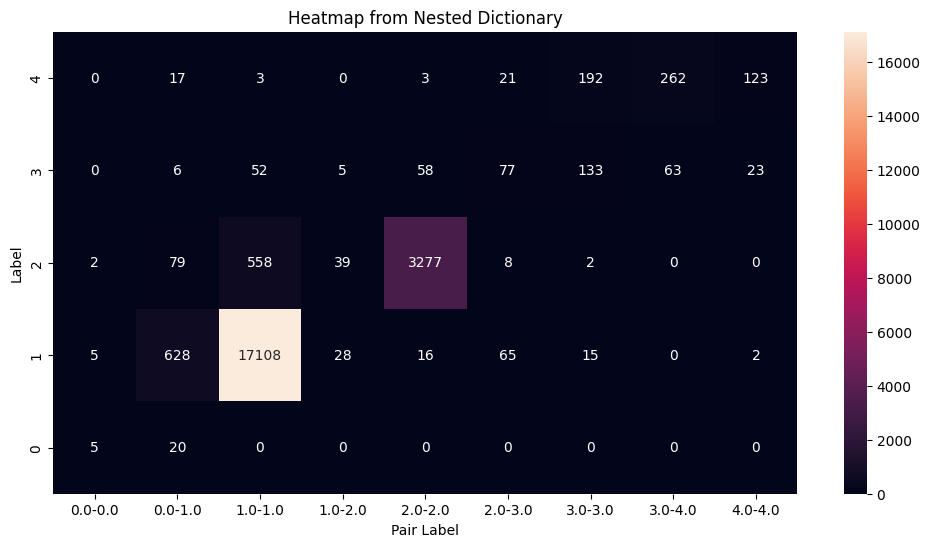

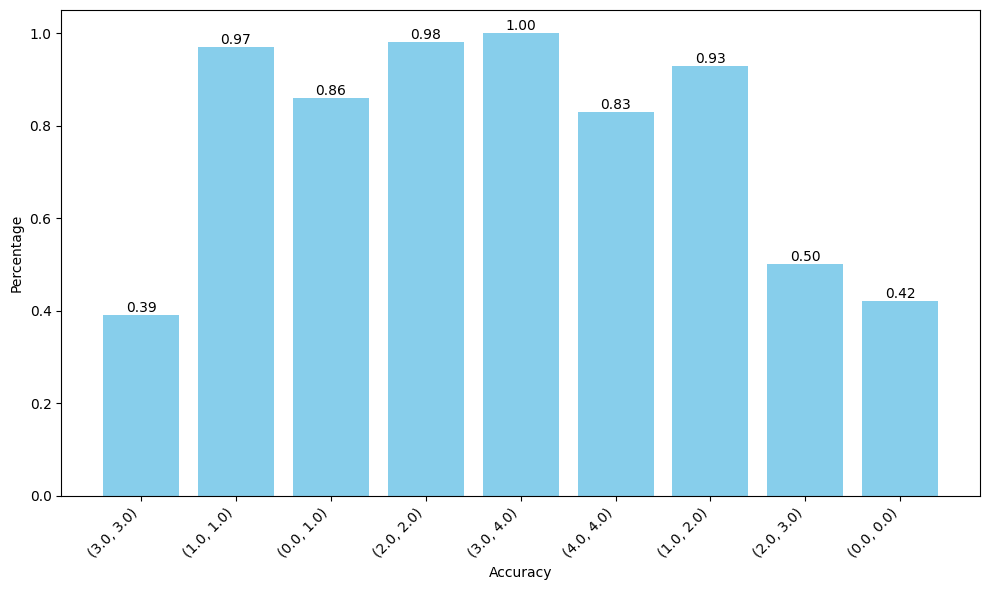

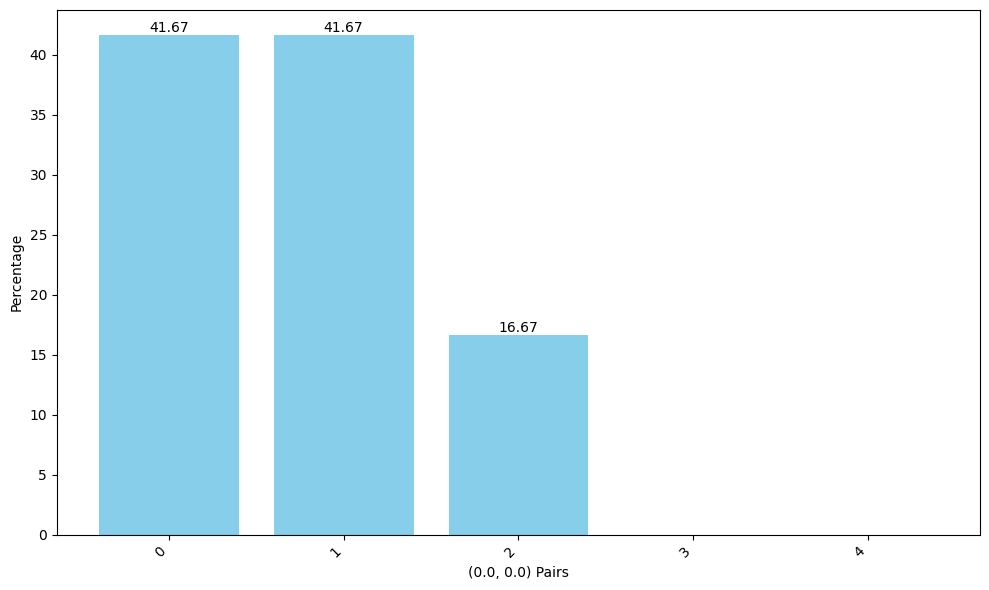

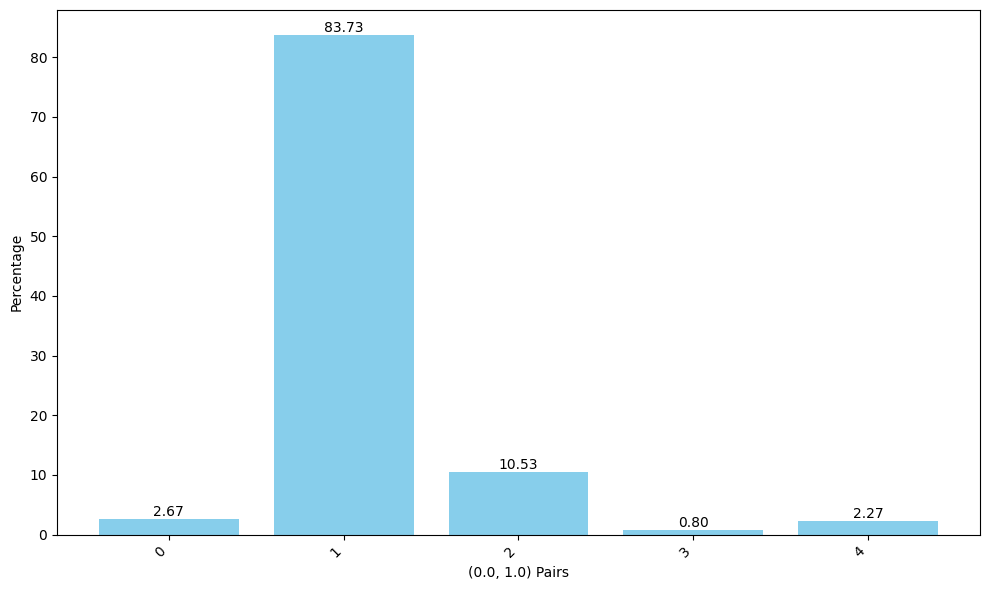

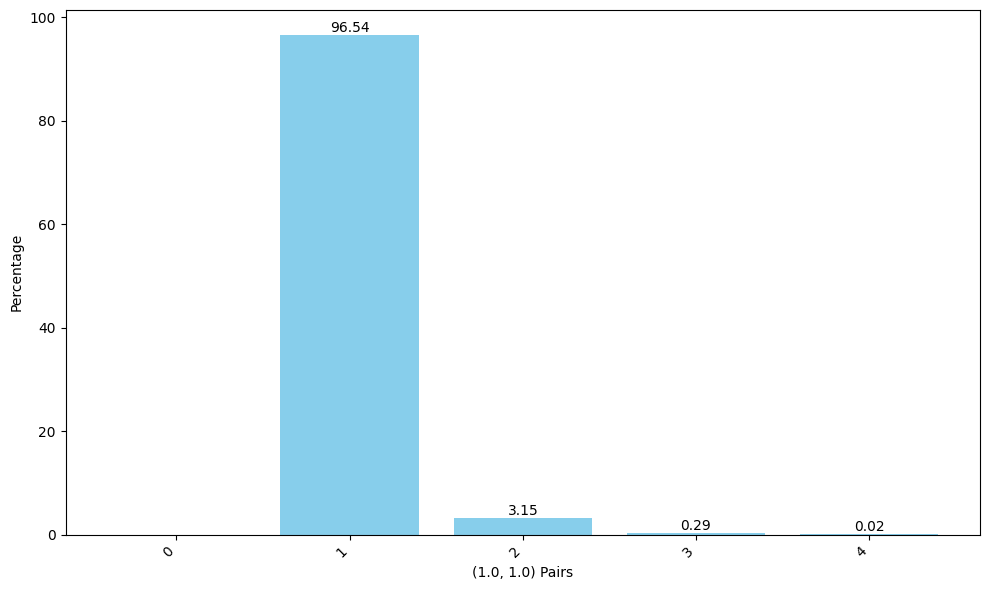

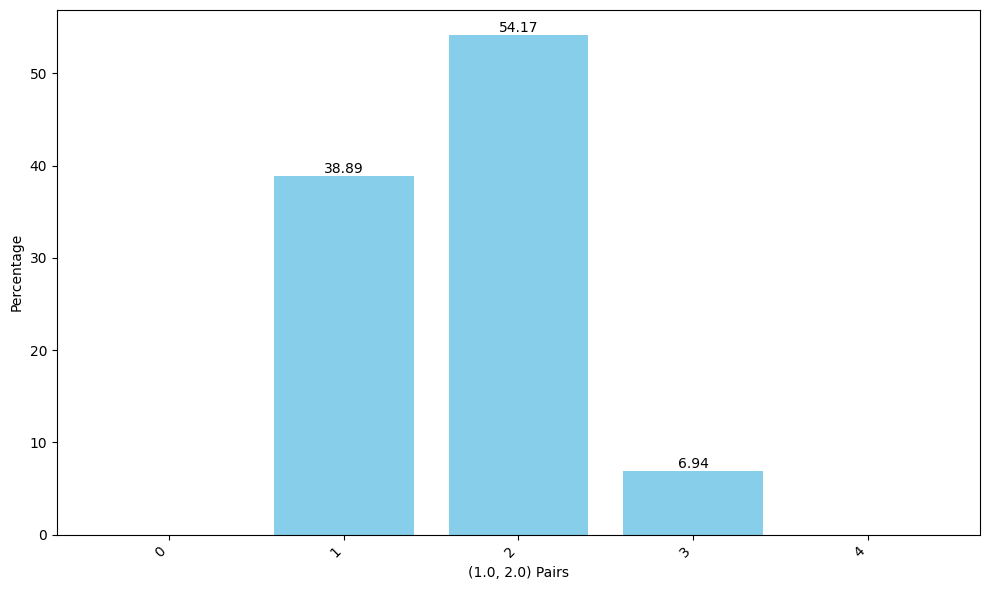

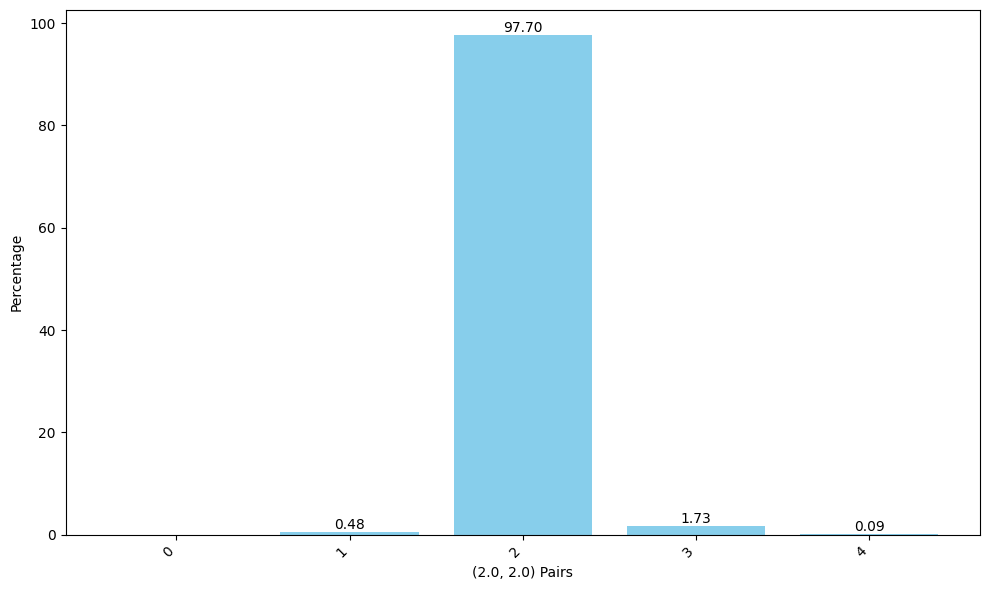

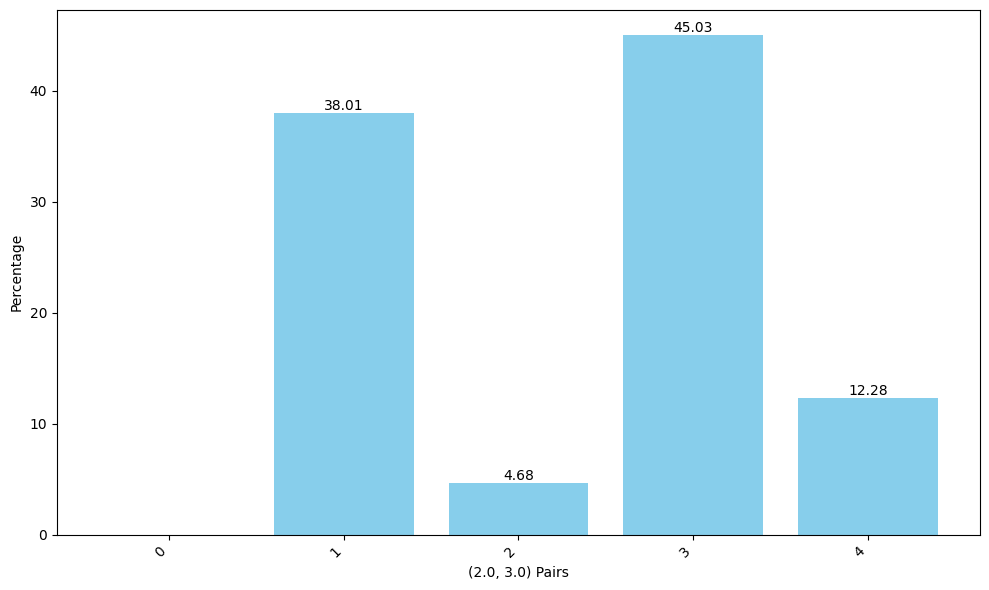

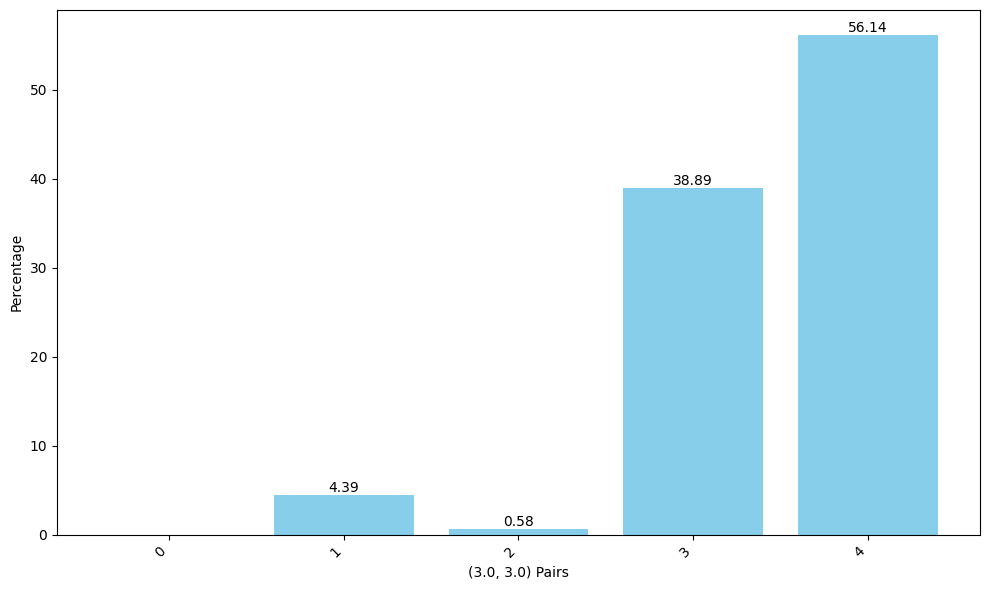

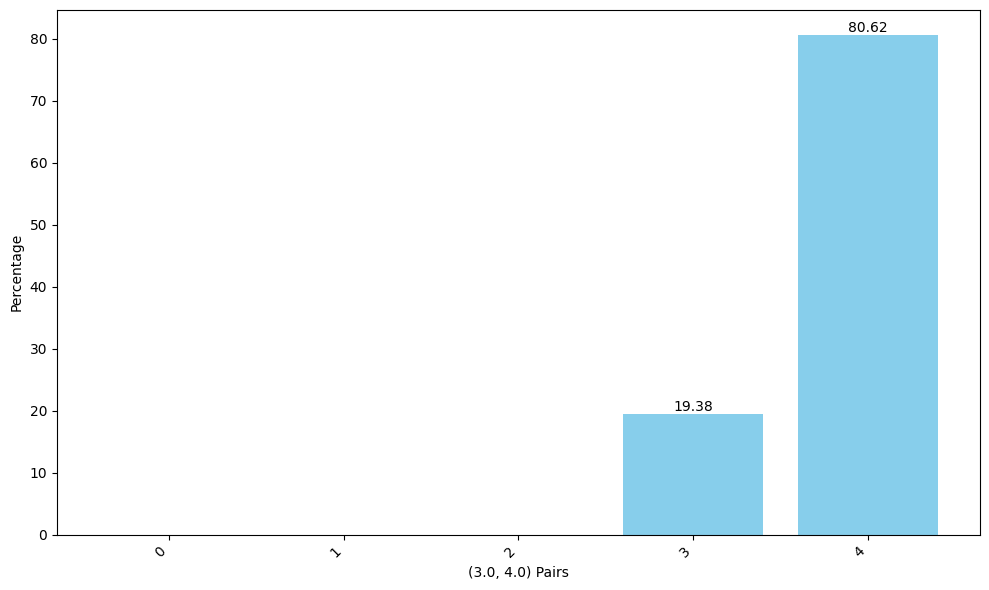

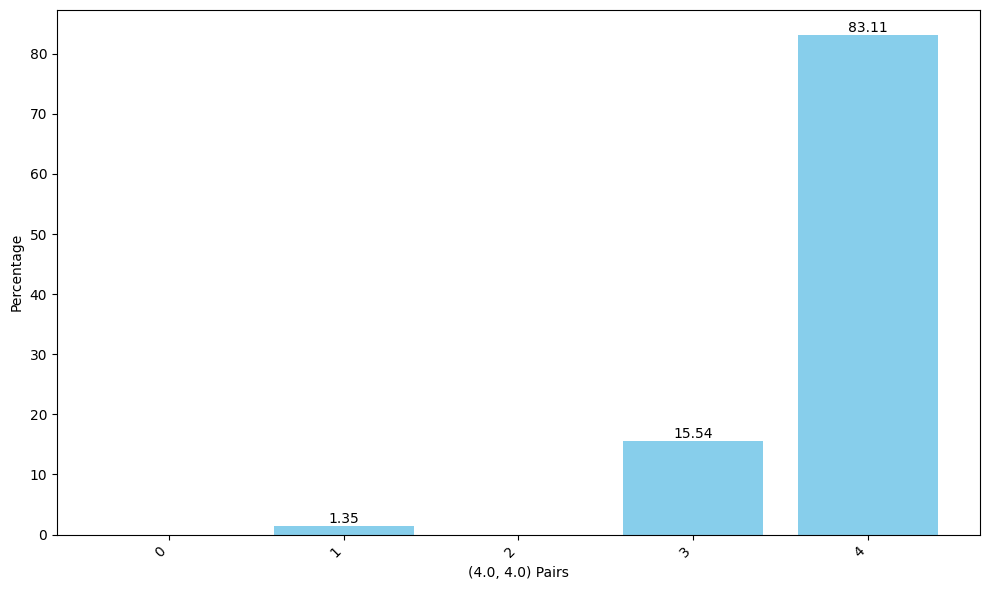

In [22]:
reporting(first_y_test, second_y_test, predicted_labels)